In [86]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from IPython.display import display, HTML


from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report


from xgboost import XGBClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import BernoulliNB, MultinomialNB

import numpy as np

# Set seaborn theme for consistent plots
sns.set_theme(style="darkgrid", palette="bright")

# Display options for wide tables
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Custom CSS for scrollable tables in notebook/PDF
display(
    HTML(
        """
<style>
.scroll-table {
    display: block;
    overflow-x: auto;
    white-space: nowrap;
}
</style>
        """
    )
)

In [87]:
df = pd.read_excel("./cleaned_data.xlsx")
df

,record_id,timepoint,ppos,ppos_s,ppos_c,age,gender,cultural_black,cultural_east_asian,cultural_indigenous,cultural_middle_eastern,cultural_latin_american,cultural_south_asian,cultural_southeast_asian,cultural_white,cultural_other,french_proficiency,english_proficiency,other_languages,other_training,prior_education,site_of_study,intended_specialization,specialty,has_dec,has_bsc,has_msc,has_doc,highest_degree,primary_care,non_primary_care,surgical,non_surgical
0,1,M2,88,40,48,21,Female,False,False,False,True,False,False,False,False,False,Fluent,Fluent,"Spanish (moderate), Arab (moderate)",NaN,"CEGEP, 2022",Montreal,Yes,Internal medicine,True,False,False,False,DEC/CEGEP,False,True,False,True
1,2,M4,75,29,46,42,Female,False,False,False,False,False,True,False,False,False,Fluent,Fluent,"Hindi, Punjabi, Urdu",NaN,Graduate studies in Experimental Medicine,Montreal,No,NaN,False,False,True,False,Masters,False,False,False,False
2,3,M3,76,38,38,30,Male,False,False,False,True,False,False,False,False,False,Moderate,Fluent,"Arabic, proficient",NaN,"Bsc, jd, llm",Montreal,Yes,Dermatology,False,True,False,True,Doctorate,False,True,False,True
3,5,M2,76,42,34,25,Male,False,False,False,False,False,False,False,True,False,Moderate,Fluent,none,NaN,"CEGEP, Bsc, Msc",Montreal,Yes,internal medicine - maybe medical oncology,True,True,True,False,Masters,False,True,False,True
4,7,M3,61,33,28,27,Male,True,False,False,False,False,False,False,False,False,Fluent,Fluent,Basic Japanese,NaN,BSc Human Kinetics 2020 BSc Translational and Molecular Medicine 2022,Montreal,Yes,Anesthesia,False,True,True,False,Masters,False,True,False,True
5,8,M1,72,35,37,18,Female,False,False,False,False,False,False,True,False,False,Fluent,Fluent,"Vietnamese, fluent",NaN,CEGEP - 2020 BSc - 2022,Montreal,Yes,Ophthalmology,True,True,False,False,Bachelors,False,True,True,False
6,10,M3,70,27,43,33,Male,False,False,False,False,False,False,False,True,False,Fluent,Fluent,Spanish,NaN,Undergrad,Montreal,Yes,Fam + ER,False,True,False,False,Bachelors,True,False,False,True
7,11,M2,75,32,43,29,Female,False,False,False,False,False,False,False,False,True,Fluent,Fluent,Armenian Spanish,NaN,"Marianopolis, 2014 Bsc, 2017, 2020 Msc, 2023",Montreal,No,NaN,False,True,True,False,Masters,False,False,False,False
8,13,M3,79,35,44,23,Female,False,True,False,False,False,False,False,False,False,Fluent,Fluent,Mandarin -fluent,NaN,Cegep 2021,Montreal,Yes,Internal medicine,True,False,False,False,DEC/CEGEP,False,True,False,True
9,14,M3,67,31,36,27,Female,False,False,False,False,False,False,False,True,False,Fluent,Fluent,"Anglais, intermédiaire",NaN,"Cegep, BSc",Outaouais,Yes,"Pediatrie, chirurgie plastique, médecine familiale",True,True,False,False,Bachelors,False,False,False,False


In [88]:
# Example: Create age group
df["age_group"] = pd.cut(
    df["age"], bins=[17, 22, 26, 30, 100], labels=["<22", "22-25", "26-29", "30+"]
)

# Example: Count number of cultural identities selected
cultural_cols = [col for col in df.columns if col.startswith("cultural_")]
df["n_cultures"] = df[cultural_cols].sum(axis=1)

# Example: Bilingual/Trilingual
df["is_bilingual"] = (
    (df["french_proficiency"] != "None") & (df["english_proficiency"] != "None")
).astype(int)
df["has_other_language"] = df["other_languages"].notnull().astype(int)

degree_map = {"DEC/CEGEP": 0, "Bachelors": 1, "Masters": 2, "Doctorate": 3}
df["degree_level"] = df["highest_degree"].map(degree_map)

df["has_specialization"] = (df["intended_specialization"] != "None").astype(int)

# combining features

# df['agegroup_deg'] = df['age_group'].astype(str) + '_' + df['highest_degree'].astype(str)

# df['bilingual_primarycare'] = df['is_bilingual'] * df['primary_care'].astype(int)

df["young_and_multicultural"] = ((df["age"] < 26) & (df["n_cultures"] > 1)).astype(int)

In [89]:
df

,record_id,timepoint,ppos,ppos_s,ppos_c,age,gender,cultural_black,cultural_east_asian,cultural_indigenous,cultural_middle_eastern,cultural_latin_american,cultural_south_asian,cultural_southeast_asian,cultural_white,cultural_other,french_proficiency,english_proficiency,other_languages,other_training,prior_education,site_of_study,intended_specialization,specialty,has_dec,has_bsc,has_msc,has_doc,highest_degree,primary_care,non_primary_care,surgical,non_surgical,age_group,n_cultures,is_bilingual,has_other_language,degree_level,has_specialization,young_and_multicultural
0,1,M2,88,40,48,21,Female,False,False,False,True,False,False,False,False,False,Fluent,Fluent,"Spanish (moderate), Arab (moderate)",NaN,"CEGEP, 2022",Montreal,Yes,Internal medicine,True,False,False,False,DEC/CEGEP,False,True,False,True,<22,1,1,1,0,1,0
1,2,M4,75,29,46,42,Female,False,False,False,False,False,True,False,False,False,Fluent,Fluent,"Hindi, Punjabi, Urdu",NaN,Graduate studies in Experimental Medicine,Montreal,No,NaN,False,False,True,False,Masters,False,False,False,False,30+,1,1,1,2,1,0
2,3,M3,76,38,38,30,Male,False,False,False,True,False,False,False,False,False,Moderate,Fluent,"Arabic, proficient",NaN,"Bsc, jd, llm",Montreal,Yes,Dermatology,False,True,False,True,Doctorate,False,True,False,True,26-29,1,1,1,3,1,0
3,5,M2,76,42,34,25,Male,False,False,False,False,False,False,False,True,False,Moderate,Fluent,none,NaN,"CEGEP, Bsc, Msc",Montreal,Yes,internal medicine - maybe medical oncology,True,True,True,False,Masters,False,True,False,True,22-25,1,1,1,2,1,0
4,7,M3,61,33,28,27,Male,True,False,False,False,False,False,False,False,False,Fluent,Fluent,Basic Japanese,NaN,BSc Human Kinetics 2020 BSc Translational and Molecular Medicine 2022,Montreal,Yes,Anesthesia,False,True,True,False,Masters,False,True,False,True,26-29,1,1,1,2,1,0
5,8,M1,72,35,37,18,Female,False,False,False,False,False,False,True,False,False,Fluent,Fluent,"Vietnamese, fluent",NaN,CEGEP - 2020 BSc - 2022,Montreal,Yes,Ophthalmology,True,True,False,False,Bachelors,False,True,True,False,<22,1,1,1,1,1,0
6,10,M3,70,27,43,33,Male,False,False,False,False,False,False,False,True,False,Fluent,Fluent,Spanish,NaN,Undergrad,Montreal,Yes,Fam + ER,False,True,False,False,Bachelors,True,False,False,True,30+,1,1,1,1,1,0
7,11,M2,75,32,43,29,Female,False,False,False,False,False,False,False,False,True,Fluent,Fluent,Armenian Spanish,NaN,"Marianopolis, 2014 Bsc, 2017, 2020 Msc, 2023",Montreal,No,NaN,False,True,True,False,Masters,False,False,False,False,26-29,1,1,1,2,1,0
8,13,M3,79,35,44,23,Female,False,True,False,False,False,False,False,False,False,Fluent,Fluent,Mandarin -fluent,NaN,Cegep 2021,Montreal,Yes,Internal medicine,True,False,False,False,DEC/CEGEP,False,True,False,True,22-25,1,1,1,0,1,0
9,14,M3,67,31,36,27,Female,False,False,False,False,False,False,False,True,False,Fluent,Fluent,"Anglais, intermédiaire",NaN,"Cegep, BSc",Outaouais,Yes,"Pediatrie, chirurgie plastique, médecine familiale",True,True,False,False,Bachelors,False,False,False,False,26-29,1,1,1,1,1,0


### XGBoost (Extreme Gradient Boosting)

XGBoost is a fast, scalable, and accurate implementation of gradient boosting. It supports regularization, handles missing data, and allows parallel processing. Commonly used for classification, regression, and ranking tasks, it is highly effective for structured/tabular data.

#### Key Parameters:
- `n_estimators`: Number of trees.
- `max_depth`: Tree depth.
- `learning_rate`: Step size.
- `subsample`: Sample fraction per tree.
- `objective`: Learning task (e.g., `binary:logistic`).

#### Pros:
- High accuracy.
- Handles missing/sparse data.
- Robust to overfitting.

#### Cons:
- Computationally intensive.
- Requires tuning for best results.


In [90]:

speciality_cols = ['primary_care', 'non_primary_care', 'surgical', 'non_surgical']
y = df[speciality_cols].astype(int)
X = df.drop(speciality_cols + ['record_id', 'specialty', 'prior_education'], axis=1 )

# encode categorical vars
X = pd.get_dummies(X, drop_first=True)
X.columns = X.columns.str.replace(r"[\[\]<>]", "", regex=True)

# using a stratified shuffled split since some have less results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=127, shuffle=True, stratify=y)

In [91]:
model = MultiOutputClassifier(XGBClassifier( eval_metric='logloss'))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=speciality_cols, zero_division=0))

                  precision    recall  f1-score   support

    primary_care       0.00      0.00      0.00         4
non_primary_care       0.77      0.83      0.80        12
        surgical       0.00      0.00      0.00         3
    non_surgical       0.79      0.79      0.79        14

       micro avg       0.66      0.64      0.65        33
       macro avg       0.39      0.40      0.40        33
    weighted avg       0.61      0.64      0.62        33
     samples avg       0.41      0.43      0.40        33



<Figure size 1500x700 with 0 Axes>

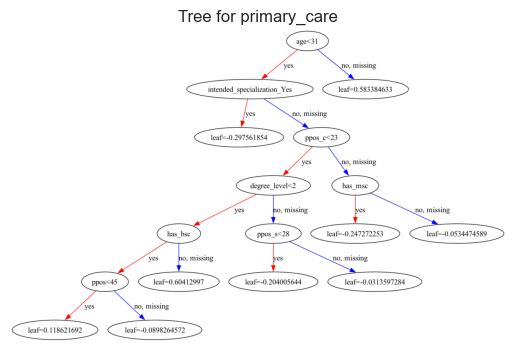

<Figure size 1500x700 with 0 Axes>

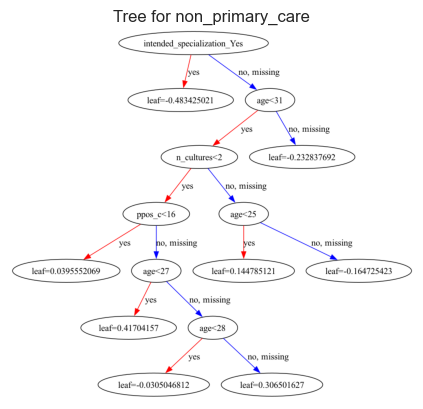

<Figure size 1500x700 with 0 Axes>

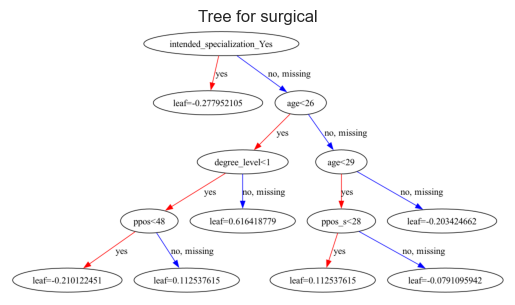

<Figure size 1500x700 with 0 Axes>

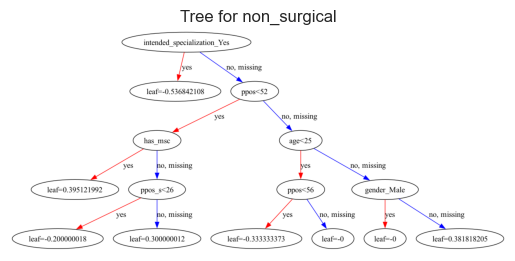

In [92]:
for i, col in enumerate(speciality_cols):
    plt.figure(figsize=(15, 7))
    plot_tree(model.estimators_[i])
    plt.title(f"Tree for {col}")
    plt.show()

### Random Forest (RF)

Random Forest is an ensemble learning method that combines multiple decision trees to improve predictive accuracy and control overfitting. It is widely used for both classification and regression tasks.

#### Key Features:
- **Bagging**: Combines predictions from multiple trees trained on random subsets of data.
- **Feature Randomness**: Selects a random subset of features for each split, reducing correlation between trees.
- **Out-of-Bag (OOB) Error**: Provides an internal estimate of model performance without the need for a separate validation set.

#### Pros:
- Handles high-dimensional data well.
- Robust to overfitting due to averaging.
- Works well with missing data.

#### Cons:
- Less interpretable compared to single decision trees.
- May require tuning for optimal performance.

In [93]:
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=123))
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=speciality_cols, zero_division=0))

                  precision    recall  f1-score   support

    primary_care       0.00      0.00      0.00         4
non_primary_care       0.69      0.75      0.72        12
        surgical       0.00      0.00      0.00         3
    non_surgical       0.75      0.64      0.69        14

       micro avg       0.69      0.55      0.61        33
       macro avg       0.36      0.35      0.35        33
    weighted avg       0.57      0.55      0.56        33
     samples avg       0.41      0.36      0.36        33



In [94]:
for i, col in enumerate(speciality_cols):
    importances = rf_model.estimators_[i].feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    print(f"Feature importances for {col}:")
    with pd.option_context('display.max_colwidth', None, 'display.width', 2000):
        print(importance_df.sort_values('importance', ascending=False).head(10).to_string(index=False))

Feature importances for primary_care:
                    feature  importance
                        age    0.105753
                       ppos    0.080446
                     ppos_c    0.075279
                     ppos_s    0.055739
              age_group_30+    0.046117
intended_specialization_Yes    0.035147
               degree_level    0.034142
               timepoint_M3    0.027482
  french_proficiency_Fluent    0.026479
                    has_dec    0.024216
Feature importances for non_primary_care:
                    feature  importance
intended_specialization_Yes    0.180985
                     ppos_s    0.084618
                       ppos    0.067874
                        age    0.065865
                     ppos_c    0.057771
               degree_level    0.033084
   highest_degree_DEC/CEGEP    0.025294
            age_group_22-25    0.018938
               timepoint_M3    0.018926
                gender_Male    0.018348
Feature importances for surgical:
      

### Logistic Regression (LogRes)

Logistic Regression is a statistical model used for binary classification tasks. It predicts the probability of an outcome based on one or more input features. The model uses the logistic function (sigmoid) to map predicted values to probabilities between 0 and 1.

In [95]:
log_model = MultiOutputClassifier(LogisticRegression(penalty='l2', class_weight='balanced', max_iter=900))
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print(classification_report(y_test, y_pred_log, target_names=speciality_cols, zero_division=0))

                  precision    recall  f1-score   support

    primary_care       0.14      0.25      0.18         4
non_primary_care       0.64      0.75      0.69        12
        surgical       0.38      1.00      0.55         3
    non_surgical       0.77      0.71      0.74        14

       micro avg       0.55      0.70      0.61        33
       macro avg       0.48      0.68      0.54        33
    weighted avg       0.61      0.70      0.64        33
     samples avg       0.35      0.45      0.38        33



### Naive Bayes (NB)

Naive Bayes is a simple probabilistic classifier based on Bayes' theorem with the assumption of independence between predictors. It is commonly used for text classification and other tasks with categorical data.

#### Key Features:
- **Assumes Feature Independence**: Simplifies computation but may not hold in real-world data.
- **Fast and Efficient**: Suitable for large datasets.

#### Pros:
- Easy to implement.
- Works well with small datasets.

#### Cons:
- Assumes strong independence, which may reduce accuracy.

In [96]:
nb_model = MultiOutputClassifier(BernoulliNB())
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=speciality_cols, zero_division=0))

                  precision    recall  f1-score   support

    primary_care       0.00      0.00      0.00         4
non_primary_care       0.75      0.75      0.75        12
        surgical       0.00      0.00      0.00         3
    non_surgical       0.73      0.79      0.76        14

       micro avg       0.74      0.61      0.67        33
       macro avg       0.37      0.38      0.38        33
    weighted avg       0.58      0.61      0.59        33
     samples avg       0.43      0.41      0.40        33



### Multinominal NB

Naive Bayes classifier for multinomial models.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [97]:
nbmodal_model = MultiOutputClassifier(MultinomialNB())
nbmodal_model.fit(X_train, y_train)
y_pred_nbmodal = nbmodal_model.predict(X_test)
print(classification_report(y_test, y_pred_nbmodal, target_names=speciality_cols, zero_division=0))

                  precision    recall  f1-score   support

    primary_care       0.00      0.00      0.00         4
non_primary_care       0.75      0.75      0.75        12
        surgical       0.00      0.00      0.00         3
    non_surgical       0.64      0.64      0.64        14

       micro avg       0.67      0.55      0.60        33
       macro avg       0.35      0.35      0.35        33
    weighted avg       0.55      0.55      0.55        33
     samples avg       0.38      0.38      0.36        33



### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique used to simplify complex datasets while retaining most of the variance. It transforms the data into a new coordinate system where the axes (principal components) are ordered by the amount of variance they capture.

#### Key Features:
- **Variance Maximization**: The first principal component captures the highest variance, followed by subsequent components.
- **Orthogonality**: Principal components are orthogonal to each other, ensuring no redundancy.
- **Dimensionality Reduction**: Reduces the number of features while preserving essential information.

#### Pros:
- Reduces computational complexity.
- Mitigates multicollinearity.
- Enhances visualization for high-dimensional data.

#### Cons:
- May lose interpretability of original features.
- Assumes linear relationships in the data.

Explained variance ratio: [0.04848544 0.02769989 0.02613049 0.02363543 0.02275525 0.01989078
 0.01860002 0.01725723 0.0166952  0.01643958 0.0153597  0.01522624
 0.01459519 0.01420566 0.01406059 0.01327526 0.01312664 0.01259733
 0.01185539 0.01158752]
Sum of explained variance ratio: 0.3734788228595096


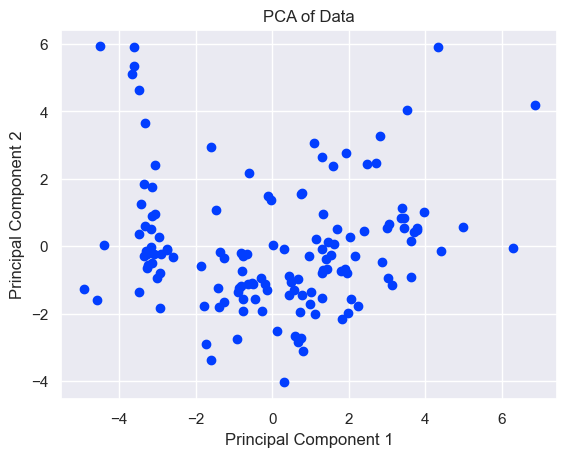

In [98]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2 principal components
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Sum of explained variance ratio:", sum(pca.explained_variance_ratio_))

import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Data')
plt.show()

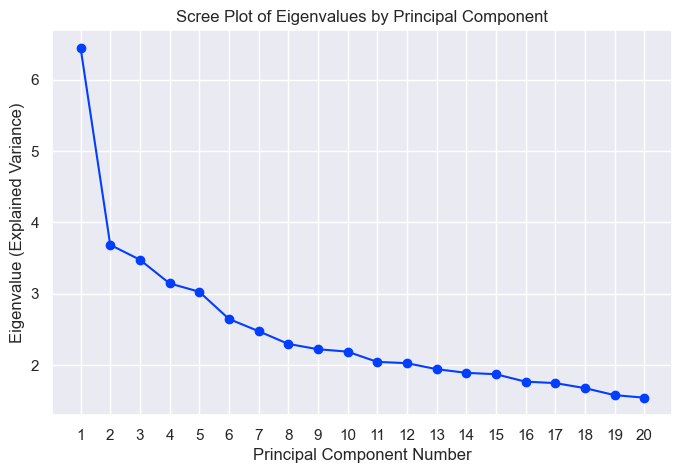

In [99]:
eigenvalues = pca.explained_variance_

# 5. Create the scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.title('Scree Plot of Eigenvalues by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.grid(True)
plt.xticks(range(1, len(eigenvalues) + 1))
plt.show()